# Configuración

In [1]:
import json
import os
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# Prerequisitos

Este notebook se debe ejecutar desde el directorio en el que se encuentra la carpeta `recipe1m_sample`. Si se ejecuta en Colab, se debe subir la carpeta desde la sección archivos.

# Análisis del dataset

El dataset [Recipe1M](http://im2recipe.csail.mit.edu/) contiene aproximadamente 1 millón de recetas extraídas de páginas web y unas 800.000 imágenes de estas recetas (no todas las recetas tienen imágenes asociadas). Estas recetas tienen una lista de ingredientes e instrucciones de preparación. De ese millón de recetas, unas 50.000 también incluyen información nutricional. Para este trabajo se va a considerar un subconjunto de esas 50.000 recetas para las que, además de información nutricional, se incluyen una o más imágenes. 
Toda la información de este subconjunto de recetas se encuentra en `recipe1m_sample/recipes.json`:

In [2]:
with open('recipe1m_sample/recipes.json', encoding='UTF-8') as f:
  recipes = json.load(f) 

A continuación se muestra el número de recetas e imágenes en total y en cada una de las particiones (entrenamiento, validación y test):

In [3]:
stats = {
  'recipes': {
    'train': 0,
    'val': 0,
    'test': 0,
  },
  'images': {
    'train': 0,
    'val': 0,
    'test': 0,
  }
}

for recipe in recipes:
  nimages = len(recipe['images'])
  stats['recipes'][recipe['partition']] += 1
  stats['images'][recipe['partition']] += nimages

print(f'{len(recipes)} recetas:')
print(f'\t{stats["recipes"]["train"]} recetas para entrenamiento')
print(f'\t{stats["recipes"]["val"]} recetas para validación')
print(f'\t{stats["recipes"]["test"]} recetas para test\n')
print(f'{sum(stats["images"].values())} imágenes:')
print(f'\t{stats["images"]["train"]} imágenes para entrenamiento')
print(f'\t{stats["images"]["val"]} imágenes para validación')
print(f'\t{stats["images"]["test"]} imágenes para test')

20232 recetas:
	14127 recetas para entrenamiento
	3003 recetas para validación
	3102 recetas para test

50718 imágenes:
	35293 imágenes para entrenamiento
	8005 imágenes para validación
	7420 imágenes para test


También es interesante conocer el tamaño del vocabulario de ingredientes y ver algunos ejemplos. Los nombres de los ingredientes son los usados por [FoodData Central](https://fdc.nal.usda.gov/), una base de datos de alimentos del Departamento de Agricultura de Estados Unidos. Esta base de datos es la más completa en cuanto a información nutricional de alimentos.



In [4]:
ingredients = set()
for recipe in recipes:
  ingredients.update(map(lambda ingr: ingr['text'], recipe['ingredients']))

print(f'{len(ingredients)} ingredientes distintos')
print('Ejemplos:')
for ingredient in list(ingredients)[:5]:
  print(f'\t"{ingredient}"')

355 ingredientes distintos
Ejemplos:
	"wild rice, raw"
	"xanthan gum, upc: 071518021764"
	"pretzels, soft, unsalted"
	"crustaceans, shrimp, raw (not previously frozen)"
	"puddings, tapioca, ready-to-eat"


A continuación se muestran algunos ejemplos de imágenes contenidas en el dataset, junto con el nombre de la receta que representan:

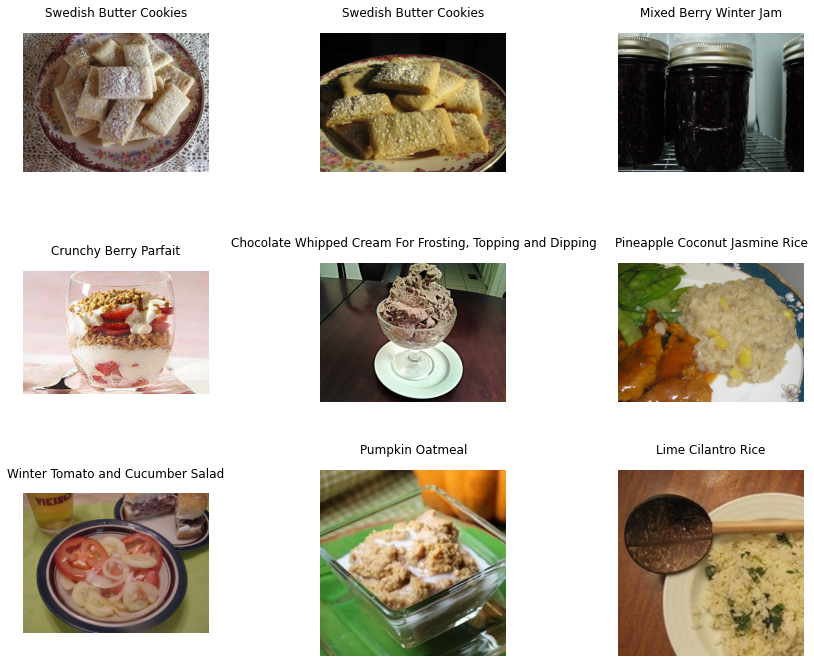

In [5]:
images = os.listdir('recipe1m_sample/sample_images')
recipes_with_img = {}

for recipe in recipes:
  for image in images:
    if image in map(lambda recipe_img: recipe_img['id'], recipe['images']):
      recipes_with_img[image] = recipe

v = list(recipes_with_img.items())
aux = v[5]
v[5] = v[4]
v[4] = aux

i = 1
plt.figure(figsize=(14, 12))
for image, recipe in v:
  plt.subplot(3, 3, i)
  plt.imshow(plt.imread(f'recipe1m_sample/sample_images/{image}'))
  plt.title(recipe['title'], pad=16)
  plt.axis("off")
  i += 1

plt.subplots_adjust(wspace=0.6)

A continuación se muestra toda la información que nos interesa de la receta "Swedish Butter Cookies", es decir, los ingredientes y sus proporciones por 100 g, su información nutricional por 100 g y sus imágenes:

Swedish Butter Cookies

Ingredientes por 100 g:
	31.48 g de butter, without salt
	27.93 g de sugars, granulated
	1.83 g de syrup, maple, canadian
	34.63 g de wheat flour, white, all-purpose, unenriched
	0.64 g de leavening agents, baking soda
	3.49 g de sugars, granulated

Información nutricional por 100 g:
	Energía: 476.81 kcal
	Grasas: 25.88 g
	Proteínas: 3.84 g
	Sal: 0.45 g
	Grasas saturadas: 15.94 g
	Azúcares: 32.56 g
	Hidratos de carbono: 59.10 g

Imágenes:


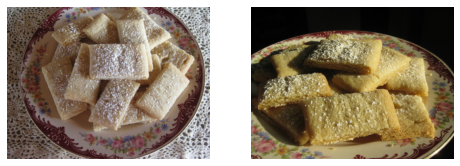

In [6]:
cookies = next(filter(
  lambda recipe: recipe['title'] == 'Swedish Butter Cookies', 
  recipes_with_img.values()
))

nutr_vals = {
  'energy': {
    'translation': 'Energía',
    'units': 'kcal'
  }, 'fat': {
    'translation': 'Grasas',
    'units': 'g'
  }, 'saturates': {
    'translation': 'Grasas saturadas',
    'units': 'g'
  }, 'protein': {
    'translation': 'Proteínas',
    'units': 'g'
  }, 'carbs': {
    'translation': 'Hidratos de carbono',
    'units': 'g'
  }, 'sugars': {
    'translation': 'Azúcares',
    'units': 'g'
  }, 'salt': {
    'translation': 'Sal',
    'units': 'g'
  }
}

print(cookies['title'])
print('\nIngredientes por 100 g:')
for ingr, weight in zip(cookies['ingredients'], cookies['weight_per_ingr']):
  print(f'\t{weight:.2f} g de {ingr["text"]}')

nutr_info = cookies['nutr_values_per100g']
print('\nInformación nutricional por 100 g:')
for key, val in cookies['nutr_values_per100g'].items():
  val_info = nutr_vals[key]
  print(f'\t{val_info["translation"]}: {val:.2f} {val_info["units"]}')

print('\nImágenes:')
i = 1
plt.figure(figsize=(8, 3))
for image in cookies['images']:
  plt.subplot(1, 2, i)
  plt.imshow(plt.imread(f'recipe1m_sample/sample_images/{image["id"]}'))
  plt.axis("off")
  i += 1

Los hidratos de carbono no se incluían en el dataset original. Se han añadido a partir de la lista de ingredientes de cada receta, de sus proporciones y de la información alojada en la base de datos [FoodData Central](https://fdc.nal.usda.gov/).

También vamos a analizar la distribución de imágenes e ingredientes por receta:

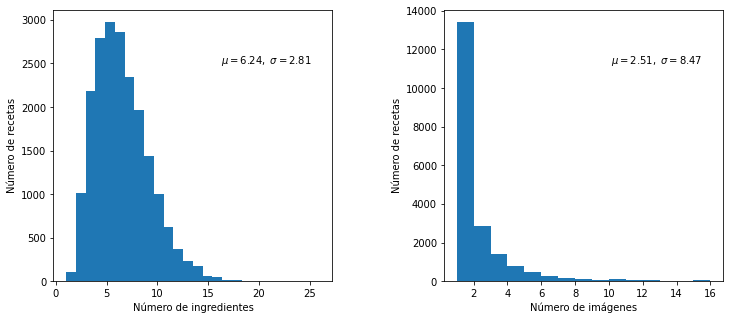

In [7]:
ingr_number_dist = list(map(lambda recipe: len(recipe['ingredients']), recipes))
img_dist = list(map(lambda recipe: len(recipe['images']), recipes))

def plot_mean_std(x, y, axis, dist, mean=None):
  if not mean:
    mean = np.mean(dist)
  text = f'$\mu={mean:.2f},\ \sigma={np.std(dist):.2f}$'
  axis.text(x, y, text, transform=axis.transAxes)

plt.figure(figsize=(12, 5))

ax = plt.subplot(1, 2, 1)
plt.hist(ingr_number_dist, bins=max(ingr_number_dist))
plt.xlabel('Número de ingredientes')
plt.ylabel('Número de recetas')
plot_mean_std(0.6, 0.8, ax, ingr_number_dist)

ax = plt.subplot(1, 2, 2)
plt.hist(img_dist, bins=15, range=(1, 16))
plt.xlabel('Número de imágenes')
plt.ylabel('Número de recetas')
plot_mean_std(0.6, 0.8, ax, img_dist)

plt.subplots_adjust(wspace=0.4)
plt.show()

Cabe destacar que en la distribución de imágenes hay outliers importantes que se excluyen de la gráfica. Si representamos esta distribución en un diagrama de caja, podemos observar el número y la magnitud de estos outliers:

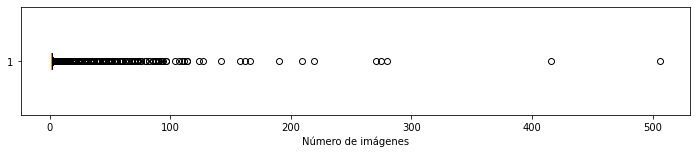

In [8]:
plt.figure(figsize=(12, 2))
plt.boxplot(img_dist, vert=False)
plt.xlabel('Número de imágenes')
plt.show()

También es interesante conocer los ingredientes más populares en el dataset. A continuación se muestra una gráfica con el número de apariciones de los 30 ingredientes más frecuentes:

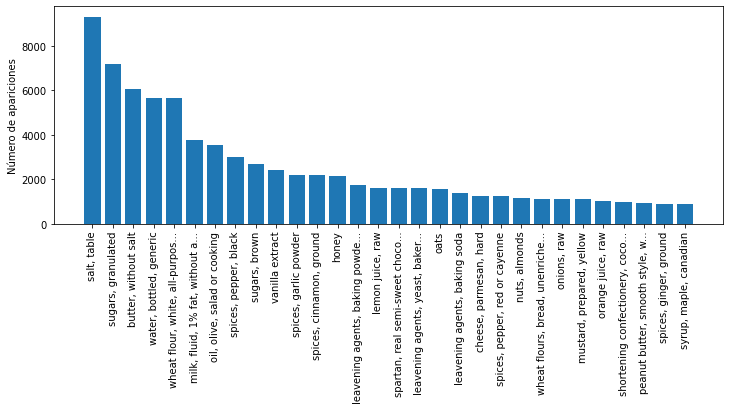

In [10]:
ingr_dist = defaultdict(lambda: 0)
for recipe in recipes:
    for ingredient in recipe['ingredients']:
        ingr_dist[ingredient['text']] += 1
top_ingrs = sorted(ingr_dist.items(), key=lambda pair: pair[1], reverse=True)[:30]
top_ingrs_names, appearances = zip(*top_ingrs)

def shorten_name(name):
    if (len(name) > 30):
        return name[:30] + '...'
    return name

top_ingrs_names = list(map(shorten_name, top_ingrs_names))
plt.figure(figsize=(12, 4))
plt.xticks(rotation='vertical')
plt.bar(top_ingrs_names, appearances)
plt.ylabel('Número de apariciones')
plt.show()

Por último, vamos a mostrar la distribución de cada valor nutricional:

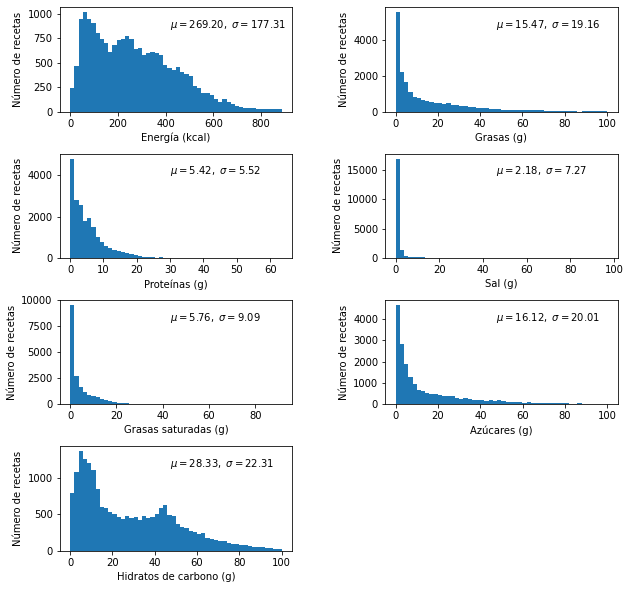

In [36]:
nutr_dist = defaultdict(lambda: np.array([]))
nutr_means = {}

for recipe in recipes:
  for key, value in recipe['nutr_values_per100g'].items():
    nutr_dist[key] = np.append(nutr_dist[key], value)

plt.figure(figsize=(10, 10))

i = 1
for key, dist in nutr_dist.items():
  nutr_means[key] = np.mean(dist)
  ax = plt.subplot(4, 2, i)
  plt.hist(dist, bins=50)
  plt.xlabel(f'{nutr_vals[key]["translation"]} ({nutr_vals[key]["units"]})')
  plt.ylabel('Número de recetas')
  plot_mean_std(0.475, 0.8, ax, dist, mean=nutr_means[key])
  i += 1

plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()